<a href="https://colab.research.google.com/github/MarianaVillegas8a/Trabajo-1-An-lisis-de-Algoritmos/blob/main/analisis_de_algoritmo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

c++, swig, python

In [22]:
!apt-get install swig
!apt-get update -qq


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 47 not upgraded.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [23]:
%%file dna.h
#include <string>
#include <vector>
#include <map>

class HMM {
public:
    std::vector<std::string> states;
    std::map<std::string, std::map<std::string, double>> emissions;
    std::map<std::string, std::map<std::string, double>> transitions;
    std::map<std::string, double> start_prob;

    HMM();
    std::string recognize(const std::string& sequence);
    double evaluate(const std::string& sequence);
};


Overwriting dna.h


In [18]:
%%file dna.cxx
#include "dna.h"
#include <cmath>

HMM::HMM() {
    states = {"H", "L"};
    start_prob["H"] = 0.5;
    start_prob["L"] = 0.5;

    transitions["H"]["H"] = 0.5;
    transitions["H"]["L"] = 0.5;
    transitions["L"]["H"] = 0.4;
    transitions["L"]["L"] = 0.6;

    emissions["H"]["A"] = 0.2;
    emissions["H"]["C"] = 0.3;
    emissions["H"]["G"] = 0.3;
    emissions["H"]["T"] = 0.2;

    emissions["L"]["A"] = 0.3;
    emissions["L"]["C"] = 0.2;
    emissions["L"]["G"] = 0.2;
    emissions["L"]["T"] = 0.3;
}

std::string HMM::recognize(const std::string& sequence) {
    std::string result;
    std::string current_state = "H";
    for (char nucleotide : sequence) {
        std::string nuc(1, nucleotide);
        double prob_H = emissions["H"][nuc] * transitions[current_state]["H"];
        double prob_L = emissions["L"][nuc] * transitions[current_state]["L"];
        current_state = (prob_H > prob_L) ? "H" : "L";
        result += current_state;
    }
    return result;
}

double HMM::evaluate(const std::string& sequence) {
    std::map<std::string, double> probs;
    for (const auto& state : states) {
        probs[state] = start_prob[state] * emissions[state][std::string(1, sequence[0])];
    }

    for (size_t i = 1; i < sequence.size(); ++i) {
        std::map<std::string, double> new_probs;
        std::string nuc(1, sequence[i]);
        for (const auto& curr : states) {
            double sum = 0.0;
            for (const auto& prev : states) {
                sum += probs[prev] * transitions[prev][curr];
            }
            new_probs[curr] = sum * emissions[curr][nuc];
        }
        probs = new_probs;
    }

    double total = 0.0;
    for (const auto& state : states) {
        total += probs[state];
    }
    return total;
}


Overwriting dna.cxx


In [19]:
%%file dna.i
%module dna

%{
#include "dna.h"
%}

%include "std_string.i"
%include "dna.h"


Overwriting dna.i


In [20]:
!swig -c++ -python dna.i
!g++ -O2 -fPIC -c dna.cxx
!g++ -O2 -fPIC -c dna_wrap.cxx -I/usr/include/python3.10
!g++ -shared dna.o dna_wrap.o -o _dna.so


In [21]:
import dna

model = dna.HMM()
sequence = "ATCGGATCGCG"

print("Sequence:", sequence)
print("Recognition:", model.recognize(sequence))
print("Evaluation:", model.evaluate(sequence))

Sequence: ATCGGATCGCG
Recognition: LLLLLLLLLLL
Evaluation: 2.2050482245264802e-07


Python

In [30]:

import math
from typing import List

class HMMModelPy:
    def __init__(self):

        self.trans = [[0.99, 0.01],[0.01,0.99]]
        self.emit = [[0.30,0.20,0.20,0.30],[0.20,0.30,0.30,0.20]]
        self.pi = [0.5, 0.5]

def base_idx_py(c):
    c = c.upper()
    if c == 'A': return 0
    if c == 'C': return 1
    if c == 'G': return 2
    if c == 'T': return 3
    return -1

def forward_prob_py(seq: str, m: HMMModelPy):
    n = len(seq)
    if n==0: return 0.0
    prev = [0.0,0.0]
    # init
    idx = base_idx_py(seq[0])
    if idx < 0: raise ValueError("Invalid base")
    for s in range(2):
        prev[s] = m.pi[s] * m.emit[s][idx]
    for i in range(1,n):
        idx = base_idx_py(seq[i])
        curr = [0.0,0.0]
        for s in range(2):
            for sp in range(2):
                curr[s] += prev[sp] * m.trans[sp][s]
            curr[s] *= m.emit[s][idx]
        prev = curr
    return prev[0] + prev[1]

def viterbi_py(seq: str, m: HMMModelPy):
    n = len(seq)
    if n==0: return []
    dp = [[-1e300]*2 for _ in range(n)]
    back = [[0]*2 for _ in range(n)]
    idx = base_idx_py(seq[0])
    for s in range(2):
        dp[0][s] = math.log(m.pi[s]) + math.log(m.emit[s][idx])
        back[0][s] = -1
    for i in range(1,n):
        idx = base_idx_py(seq[i])
        for s in range(2):
            best = -1e300
            best_state = 0
            for sp in range(2):
                score = dp[i-1][sp] + math.log(m.trans[sp][s]) + math.log(m.emit[s][idx])
                if score > best:
                    best = score
                    best_state = sp
            dp[i][s] = best
            back[i][s] = best_state

    if dp[n-1][1] > dp[n-1][0]:
        cur = 1
    else:
        cur = 0
    path = [0]*n
    for i in range(n-1, -1, -1):
        path[i] = cur
        cur = back[i][cur]
        if i==0: break
    return path


Tiempo

In [34]:
import random, time

# Generador de secuencias DNA
random.seed(42)

def random_dna(length):
    return ''.join(random.choice('ACGT') for _ in range(length))

# tamaño de prueba
N = 20000
seq_test = random_dna(N)

# Modelo Python
model_py = HMMModelPy()

# Modelo C++ con SWIG
model_cpp = dna.HMM()

# Evaluación Forward
t0 = time.perf_counter()
prob_cpp = model_cpp.evaluate(seq_test)
t1 = time.perf_counter()
dt_cpp_eval = t1 - t0

t0 = time.perf_counter()
prob_py = forward_prob_py(seq_test, model_py)
t1 = time.perf_counter()
dt_py_eval = t1 - t0

# Viterbi Recognition
t0 = time.perf_counter()
labels_cpp = model_cpp.recognize(seq_test)
t1 = time.perf_counter()
dt_cpp_vit = t1 - t0

t0 = time.perf_counter()
labels_py = viterbi_py(seq_test, model_py)
t1 = time.perf_counter()
dt_py_vit = t1 - t0

# ----------------------------
# Resultados
# ----------------------------
print(f"Longitud secuencia: {N}")
print("      EVALUACIÓN    ")
print(f"C++/SWIG tiempo: {dt_cpp_eval:.6f} s, prob: {prob_cpp:.6e}")
print(f"Python tiempo:   {dt_py_eval:.6f} s, prob: {prob_py:.6e}")
print()
print("       VITERBI (Reconocimiento)      ")
print(f"C++/SWIG tiempo: {dt_cpp_vit:.6f} s, etiquetas obtenidas: {len(labels_cpp)}")
print(f"Python tiempo:   {dt_py_vit:.6f} s, etiquetas obtenidas: {len(labels_py)}")



Longitud secuencia: 20000
      EVALUACIÓN    
C++/SWIG tiempo: 0.007367 s, prob: 0.000000e+00
Python tiempo:   0.018996 s, prob: 0.000000e+00

       VITERBI (Reconocimiento)      
C++/SWIG tiempo: 0.004277 s, etiquetas obtenidas: 20000
Python tiempo:   0.043843 s, etiquetas obtenidas: 20000


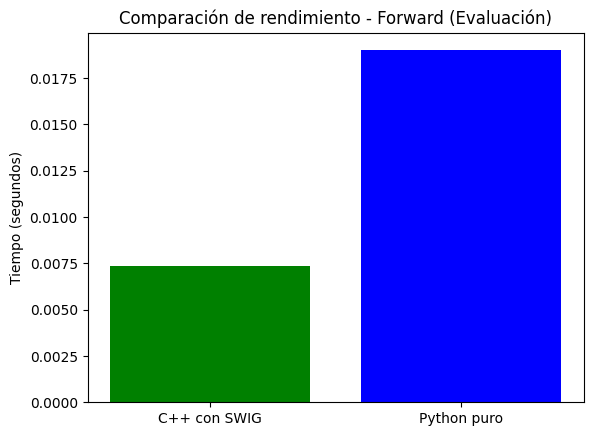

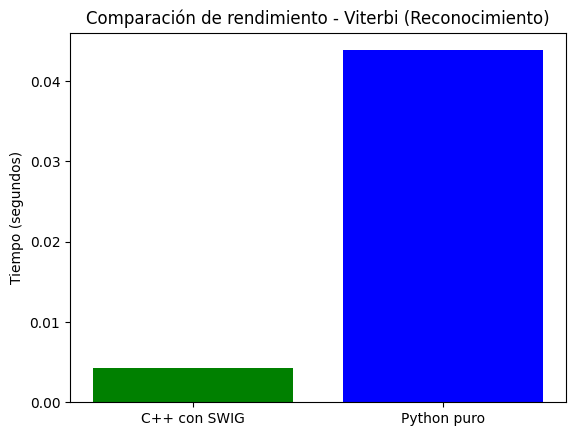

In [35]:
import matplotlib.pyplot as plt

labels = ['C++ con SWIG', 'Python puro']
times_eval = [dt_cpp_eval, dt_py_eval]

plt.bar(labels, times_eval, color=['green', 'blue'])
plt.ylabel('Tiempo (segundos)')
plt.title('Comparación de rendimiento - Forward (Evaluación)')
plt.show()

times_vit = [dt_cpp_vit, dt_py_vit]

plt.bar(labels, times_vit, color=['green', 'blue'])
plt.ylabel('Tiempo (segundos)')
plt.title('Comparación de rendimiento - Viterbi (Reconocimiento)')
plt.show()
